In [91]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [92]:
raw_data = pd.read_csv('prices.csv')
raw_data.head()

,delivery_start_utc,delivery_end_utc,price
0,21.03.2021 22:00:00,21.03.2021 23:00:00,244.29
1,21.03.2021 21:00:00,21.03.2021 22:00:00,260.00
2,21.03.2021 20:00:00,21.03.2021 21:00:00,265.00
3,21.03.2021 19:00:00,21.03.2021 20:00:00,286.10
4,21.03.2021 18:00:00,21.03.2021 19:00:00,295.79


In [93]:
y = raw_data['price']
dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
y.index = dates
y = y.sort_index()

y.head()

delivery_start_utc
2010-01-01 00:00:00    129.30
2010-01-01 01:00:00    110.17
2010-01-01 02:00:00    104.46
2010-01-01 03:00:00    105.00
2010-01-01 04:00:00    105.01
Name: price, dtype: float64

In [94]:
y.tail()

delivery_start_utc
2021-03-21 18:00:00    295.79
2021-03-21 19:00:00    286.10
2021-03-21 20:00:00    265.00
2021-03-21 21:00:00    260.00
2021-03-21 22:00:00    244.29
Name: price, dtype: float64

In [95]:
N_HOURS = 24
N_DAYS = 30

y_train, y_test = temporal_train_test_split(y, test_size=N_HOURS*N_DAYS)
print(f'y_train shape: {y_train.shape[0]}, y_test_shape: {y_test.shape[0]} ')

y_train shape: 97631, y_test_shape: 720 


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

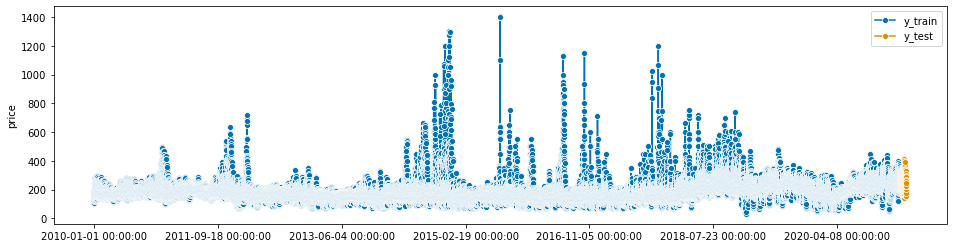

In [96]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

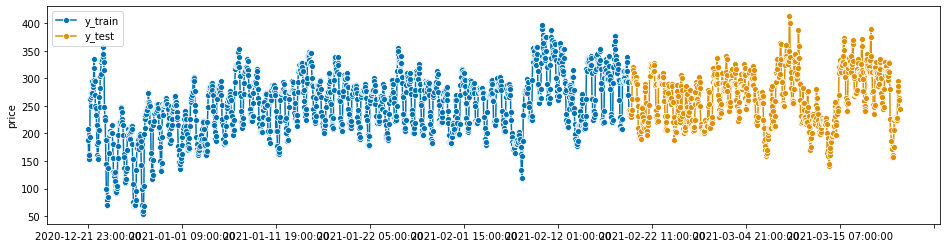

In [97]:
N_MONTHS = 2
plot_series(y_train.iloc[-N_MONTHS*N_DAYS*N_HOURS:], y_test, labels=['y_train', 'y_test'])

In [98]:
TEST_SAMPLE = 24*7

y_train_sample = y_train.iloc[-N_MONTHS*N_DAYS*N_HOURS:]
y_test_sample = y_test.iloc[:TEST_SAMPLE]

In [111]:
naive_forecaster = NaiveForecaster(strategy='last', sp=24)
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index
fh_index.freq = 'H'
fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
# plot_series(y_train_sample, y_test_sample, y_pred_sample, 
#             labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

AttributeError: The `freq` attribute of the time index is required, but found: None. Please specify the `freq` argument when setting the time index.

In [109]:
fh

ForecastingHorizon(['2021-02-19 23:00:00', '2021-02-20 00:00:00',
               '2021-02-20 01:00:00', '2021-02-20 02:00:00',
               '2021-02-20 03:00:00', '2021-02-20 04:00:00',
               '2021-02-20 05:00:00', '2021-02-20 06:00:00',
               '2021-02-20 07:00:00', '2021-02-20 08:00:00',
               ...
               '2021-02-26 13:00:00', '2021-02-26 14:00:00',
               '2021-02-26 15:00:00', '2021-02-26 16:00:00',
               '2021-02-26 17:00:00', '2021-02-26 18:00:00',
               '2021-02-26 19:00:00', '2021-02-26 20:00:00',
               '2021-02-26 21:00:00', '2021-02-26 22:00:00'],
              dtype='datetime64[ns]', name='delivery_start_utc', length=168, freq='H', is_relative=False)